<a href="https://colab.research.google.com/github.com/Fra-Sala/gnn_time/blob/main/notebook/11_lid_cavity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install PyTorch
try:
  import torch
except ImportError:
  !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
  import torch

In [2]:
# Install PyG
try:
  import torch_geometric
except ImportError:
  !pip3 install torch_geometric
  import torch_geometric

In [3]:
!pip install -Uqq ipdb
import ipdb

In [4]:
# Clone and import gca-rom
#!git clone https://github.com/Fra-Sala/gnn_time.git
import sys
sys.path.append('gnn_time') #sys.path.append('./..')
from gca_rom import network, pde, loader, plotting, preprocessing, training, initialization, testing, error, gui


In [5]:
import numpy as np
from itertools import product

# Define PDE problem

In [6]:
problem_name, variable, mu_space, n_param = pde.problem(11)
print("\nProblem: ", problem_name)
print("Variable: ", variable)
print("Parameters: ", n_param)
argv = gui.hyperparameters_selection(problem_name, variable, n_param)

# Change the training rate "manually"
argv[5] = 70  

HyperParams = network.HyperParams(argv)

> /home/francesco/Desktop/SEMESTER_PROJECT_2/gnn_time/gca_rom/pde.py(148)problem()
    147             ipdb.set_trace()
--> 148             n_param = 2
    149 



ipdb>  c



Problem:  lid_cavity
Variable:  U
Parameters:  2


# Initialize device and set reproducibility

In [7]:
device = initialization.set_device()
initialization.set_reproducibility(HyperParams)
initialization.set_path(HyperParams)

Device used:  cpu


# Load dataset

In [8]:
#dataset_dir = '../dataset/'+problem_name+'_unstructured.mat'
## If in google colab
dataset_dir = '/content/gnn_time/dataset/'+problem_name+'_unstructured.mat'
dataset = loader.LoadDataset(dataset_dir, variable)

graph_loader, train_loader, test_loader, \
    val_loader, scaler_all, scaler_test, xyz, VAR_all, VAR_test, \
        train_trajectories, test_trajectories = preprocessing.graphs_dataset(dataset, HyperParams)

params = torch.tensor(np.array(list(product(*mu_space))))
params = params.to(device)


Number of nodes processed:  15681
Number of graphs processed:  30
Length of train dataset:  9
Length of test dataset:  21


# Define the architecture

In [9]:
model = network.Net(HyperParams)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=HyperParams.learning_rate, weight_decay=HyperParams.weight_decay)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=HyperParams.miles, gamma=HyperParams.gamma)

# Train or load a pre-trained network

In [10]:
try:
    model.load_state_dict(torch.load(HyperParams.net_dir+HyperParams.net_name+HyperParams.net_run+'.pt', map_location=torch.device('cpu')))
    print('Loading saved network')
except FileNotFoundError:
    print('Training network')
    training.train(model, optimizer, device, scheduler, params, train_loader, test_loader, train_trajectories, test_trajectories, HyperParams)

Training network


100%|█| 50/50 [00:54<00:00,  1.09s/it, Loss(training)=0.619, Loss(validation)=1.


Loading best network for epoch:  33


# Evaluate the model

In [11]:
model.to("cpu")
params = params.to("cpu")
vars = "GCA-ROM"
results, latents_map, latents_gca = testing.evaluate(VAR_all, model, graph_loader, params, HyperParams, range(params.shape[0]))

100%|███████████████████████████████████████████| 30/30 [00:01<00:00, 17.58it/s]


# Plot the results

100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 25.33it/s]


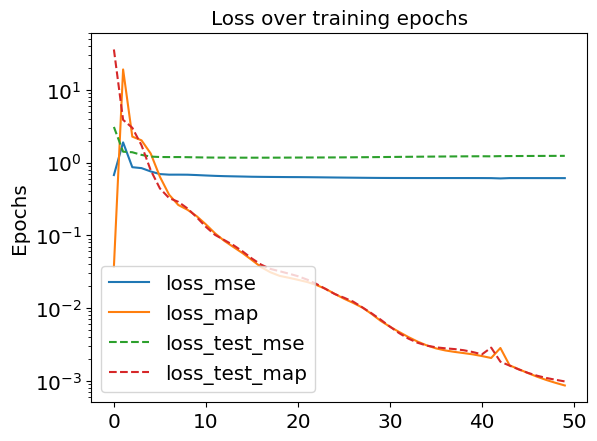

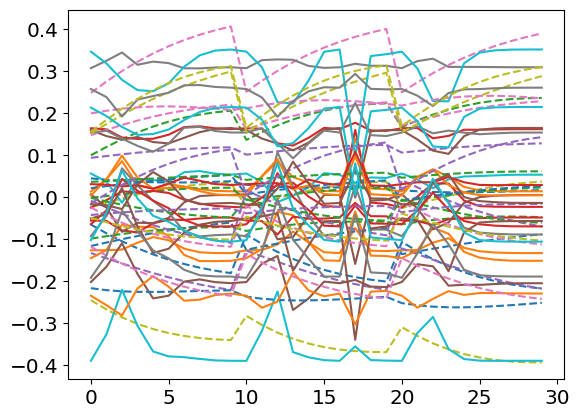

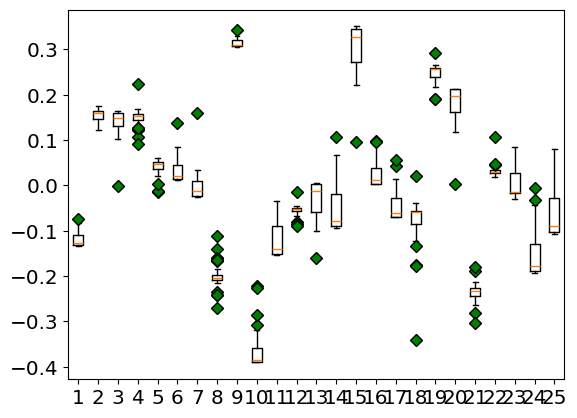

In [12]:
plotting.plot_loss(HyperParams)
plotting.plot_latent(HyperParams, latents_map, latents_gca)
#plotting.plot_error(results, VAR_all, scaler_all, HyperParams, mu_space, params, train_trajectories, vars)

N = 5
snapshots = np.arange(params.shape[0]).tolist()
np.random.shuffle(snapshots)
# for SNAP in snapshots[0:N]:
#     plotting.plot_fields(SNAP, results, scaler_all, HyperParams, dataset, xyz, params)
#     plotting.plot_error_fields(SNAP, results, VAR_all, scaler_all, HyperParams, dataset, xyz, params)

results_test, _, _ = testing.evaluate(VAR_test, model, val_loader, params, HyperParams, test_trajectories)

# Print the errors on the testing set

In [13]:
error_abs, norm = error.compute_error(results_test, VAR_test, scaler_test, HyperParams)
error.print_error(error_abs, norm, vars)
error.save_error(error_abs, norm, HyperParams, vars)


Maximum absolute error for field GCA-ROM =  103.9684075591921
Mean absolute error for field GCA-ROM =  23.237607821050233
Minimum absolute error for field GCA-ROM =  2.034020867665624

Maximum relative error for field GCA-ROM =  2.2845788065644404e+16
Mean relative error for field GCA-ROM =  2173444503740559.2
Minimum relative error for field GCA-ROM =  0.21283664255898094


In [ ]:
#!zip -r /content/lid_cavity.zip /content/lid_cavity